# **Project Name**    - Online Retail Customer Segmentation



##### **Project Type**    - Unsupervised ML
##### **Contribution**    - Team
##### **Team Member 1 -** Pranay Kuthe
##### **Team Member 2 -** Vipil Khapre

# **Project Summary -**

In this project, your task is to identify major customer segments on a
transnational data set which contains all the transactions occurring between
01/12/2010 and 09/12/2011 for a UK-based and registered non-store online
retail.The company mainly sells unique all-occasion gifts. Many customers of
the company are wholesalers

Customer segmentation is an important process for any retail business as it helps in understanding customer behavior, preferences, and needs. Online retail customer segmentation can be achieved by analyzing customer data such as purchase history, website behavior, demographics, and social media engagement. Here are some common ways to segment online retail customers:

Demographic segmentation: This involves segmenting customers based on age, gender, income, education, and other demographic characteristics. This can help identify customer groups with similar needs and preferences. Behavioral segmentation: This involves segmenting customers based on their behavior on the website such as purchase history, browsing behavior, and time spent on the website. This can help identify loyal customers, frequent shoppers, and first-time buyers. Geographic segmentation: This involves segmenting customers based on their location such as country, region, city, or zip code. This can help identify customers in different geographic areas with different needs and preferences. Psychographic segmentation: This involves segmenting customers based on their personality, lifestyle, interests, and values. This can help identify customer groups with similar psychographic characteristics and tailor marketing messages to their specific needs. Purchase history segmentation: This involves segmenting customers based on their past purchase behavior such as the frequency of purchase, average order value, and type of products purchased. This can help identify high-value customers, product preferences, and buying patterns. By analyzing customer data through these segmentation methods, online retailers can create targeted marketing campaigns, personalized recommendations, and customer experiences that meet the unique needs of each customer group.

# **Project Statement -**

# **GitHub Link -**

# ***Let's Begin !***

## ***1. Know Your Data***

### Import Libraries

In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

### Dataset Loading

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load Dataset
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Python_For_DS_Week1_11 01 23/Projects/ML/Online Retail.xlsx')

In [4]:
preserved_data = df.copy() # Creating a copy for the dataset

### Dataset First View

In [5]:
# Dataset First Look
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Dataset Rows & Columns count

In [6]:
# Dataset Rows & Columns count
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns available in the dataset")

There are 541909 rows and 8 columns available in the dataset


### Dataset Information

In [7]:
# Dataset Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


#### Duplicate Values

In [8]:
# Dataset Duplicate Value Count
df.duplicated().sum()

5268

In [9]:
# Removing duplicates
df.drop_duplicates(inplace = True)

In [10]:
# Checking the if is there any duplicate values left after droping the duplicate values
df.duplicated().sum()

0

#### Missing Values/Null Values

In [11]:
# Missing Values/Null Values Count
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64

<Axes: >

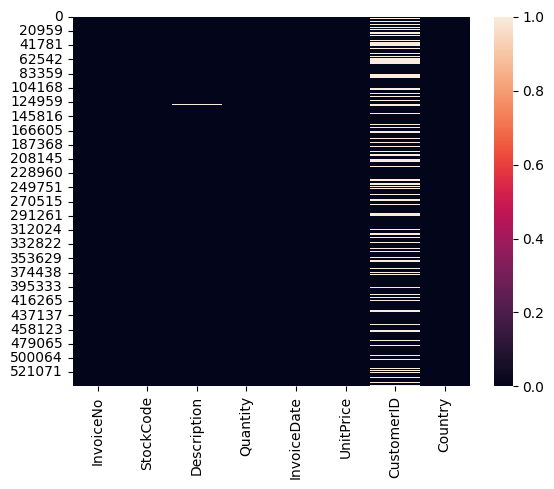

In [12]:
# Visualizing the missing values again with the help of heatmap
sns.heatmap(df.isna())

##### What did you know about your dataset?

Percentage of customers missing:  25.16 %

Check if InvoiceNo for Null Customer ID exist in cases where Customer ID is present for filling CustomerID Nulls


- No such cases present as empty dataframe is returned

In [13]:
null_id_invoices = df[df.CustomerID.isnull()]["InvoiceNo"].drop_duplicates().tolist()
print("Invoices count with Null Customer ID", len(null_id_invoices))

### Check if InvoiceNo in Null CustomerID dataframe exist in Non-Null Customer ID Dataframe
df[~df.CustomerID.isnull()][df.InvoiceNo.isin(null_id_invoices)]


Invoices count with Null Customer ID 3710


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


Since the customer ID's are missing, I assume these orders were not made by the customers already in the data set because those customers already have ID's. I also don't want to assign these orders to those customers because this would alter the insights I draw from the data. Instead of dropping the null CustomerID values which amounts to ~25% of data, let's assign those rows a unique customer ID per order using InvoiceNo. This will act as a new customer for each unique order.



Check if InvoiceNo has unique mapping with Customer ID so that each InvoiceNo corresponding to Null CustomerID can be assigned as New Customer



In [14]:
df.groupby(['InvoiceNo'])['CustomerID'].nunique().reset_index(name='nunique').sort_values(['nunique'], ascending=False).head(5)

,InvoiceNo,nunique
0,536365,1
16915,571200,1
16924,571215,1
16923,571214,1
16922,571213,1


On sorting descending, this data shows that each Invoice relates to maximum of 1 Customer

Creating NewID column and Assigning to InvoiceNo wherever CustomerID is null

In [15]:
df['NewID'] = df['CustomerID']
df.loc[df['CustomerID'].isnull(), ['NewID']] = df['InvoiceNo']

#Remove all non digits from column NewID (Since Invoice can contains "C" referring to cancellations)
df['NewID'] = df['NewID'].astype(str).str.replace('\D+', '')

#Convert to integer
df['NewID'] = pd.to_numeric(df['NewID'])

### Check if presnt customerIds and New Ids have any common values since it would create alter actual Customer Insights
customer = df['CustomerID'].nunique()
null_invoices = df[df.CustomerID.isnull()]['InvoiceNo'].nunique()
new_ids = df['NewID'].nunique()
print("Number of Customers:", customer)
print("Number of Orders where CustomerID in Null:", null_invoices)
print("Number of Customers + Number of Orders where CustomerID in Null:", customer + null_invoices)
print("Number of New ID's:", new_ids)

Number of Customers: 4372
Number of Orders where CustomerID in Null: 3710
Number of Customers + Number of Orders where CustomerID in Null: 8082
Number of New ID's: 8082


Since both values equal, we know all the different orders that didn't have a customer ID got assigned unique NewID and no duplicates were created



In [16]:
df.drop(['CustomerID'], axis=1, inplace = True)
df = df.rename(columns = {'NewID': 'CustomerID'})
df.dropna(inplace = True)

##### Converting object type to datetime for InvoiceDate and checking first and last dates


In [17]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
print("Minimum Invoice Date", min(df["InvoiceDate"]))
print("Maximum Invoice Date", max(df["InvoiceDate"]))

Minimum Invoice Date 2010-12-01 08:26:00
Maximum Invoice Date 2011-12-09 12:50:00


## ***2. Understanding Your Variables***

In [18]:
# Dataset Columns
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'Country', 'CustomerID'],
      dtype='object')

In [19]:
# Dataset Describe
df.describe()

,Quantity,UnitPrice,CustomerID
count,535187.000000,535187.000000,535187.000000
mean,9.671593,4.645242,253964.894459
std,219.059056,97.364810,176159.542227
min,-80995.000000,-11062.060000,123460.000000
25%,1.000000,1.250000,143560.000000
50%,3.000000,2.080000,162420.000000
75%,10.000000,4.130000,182830.000000
max,80995.000000,38970.000000,581498.000000


### Variables Description

- InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
- StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
- Description: Product (item) name. Nominal.
- Quantity: The quantities of each product (item) per transaction. Numeric.
- InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
- UnitPrice: Unit price. Numeric, Product price per unit in sterling.
- CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
- Country: Country name. Nominal, the name of the country where each customer resides

### Check Number of Unique Values for each variable.

In [20]:
# Check No. of Unique Values for each variable.
for i in df.columns:
  print("No. of unique values in",i,"is",df[i].nunique())

No. of unique values in InvoiceNo is 24446
No. of unique values in StockCode is 3958
No. of unique values in Description is 4223
No. of unique values in Quantity is 671
No. of unique values in InvoiceDate is 22309
No. of unique values in UnitPrice is 1630
No. of unique values in Country is 38
No. of unique values in CustomerID is 6628


### Creating new columns

In [21]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df["year"]  = df["InvoiceDate"].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day']   = df['InvoiceDate'].dt.day
df["hour"]  = df["InvoiceDate"].dt.hour

The time part of the column is not used because, time of the day does not influence the orders to a large extent.

In [22]:
# Creating a new feature 'TotalAmount' by multiplying Quantity and UnitPrice
df['TotalAmount']= df['UnitPrice'] * df['Quantity']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,CustomerID,year,Month,Day,hour,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,178500,2010,12,1,8,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,178500,2010,12,1,8,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34


In [23]:
# Creating a new feature 'TimeType' based on hours to define whether its Morning,Afternoon or Evening
df['TimeType'] = np.where((df["hour"]>5)&(df["hour"]<18), np.where(
                           df["hour"]<12, 'Morning','Afternoon'),'Evening')

In [24]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,CustomerID,year,Month,Day,hour,TotalAmount,TimeType
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,178500,2010,12,1,8,15.30,Morning
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,178500,2010,12,1,8,22.00,Morning
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 535187 entries, 0 to 541908
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    535187 non-null  object        
 1   StockCode    535187 non-null  object        
 2   Description  535187 non-null  object        
 3   Quantity     535187 non-null  int64         
 4   InvoiceDate  535187 non-null  datetime64[ns]
 5   UnitPrice    535187 non-null  float64       
 6   Country      535187 non-null  object        
 7   CustomerID   535187 non-null  int64         
 8   year         535187 non-null  int64         
 9   Month        535187 non-null  int64         
 10  Day          535187 non-null  int64         
 11  hour         535187 non-null  int64         
 12  TotalAmount  535187 non-null  float64       
 13  TimeType     535187 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(6), object(5)
memory usage: 61.2+ MB


It is known that some of the orders have been cancelled, the invoice numbers of these orders start with a 'C'. The cancelled orders are also removed.

In [26]:
# Converting the column to a string type to detect 'C'
df['InvoiceNo'] = df['InvoiceNo'].apply(str)

In [27]:
df['Cancelled'] = df['InvoiceNo'].apply(lambda x: 'Yes' if 'C' in x else 'No' )

In [28]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,CustomerID,year,Month,Day,hour,TotalAmount,TimeType,Cancelled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,178500,2010,12,1,8,15.30,Morning,No
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning,No
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,178500,2010,12,1,8,22.00,Morning,No
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning,No
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning,No


In [29]:
df.drop(df[df['Cancelled']=='Yes'].index, inplace=True)

In [30]:
df[df['Cancelled']=='Yes']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,CustomerID,year,Month,Day,hour,TotalAmount,TimeType,Cancelled


In [31]:
df.drop('Cancelled', axis=1,inplace=True)

In [32]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,CustomerID,year,Month,Day,hour,TotalAmount,TimeType
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,178500,2010,12,1,8,15.30,Morning
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,178500,2010,12,1,8,22.00,Morning
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning


This shows that quantity is negative when any order was cancelled. Removed cancellations data since they only make upto ~2% of data



#### Stock code and Item description represent the same thing, but item description describes it more clearly. Hence, we can drop the stock code.

In [33]:
# Dropping Stock Code column
df.drop('StockCode', axis = 1, inplace = True)

In [34]:
df.head()

,InvoiceNo,Description,Quantity,InvoiceDate,UnitPrice,Country,CustomerID,year,Month,Day,hour,TotalAmount,TimeType
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,178500,2010,12,1,8,15.30,Morning
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,178500,2010,12,1,8,22.00,Morning
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning


In [35]:
df.describe()

,Quantity,UnitPrice,CustomerID,year,Month,Day,hour,TotalAmount
count,525936.000000,525936.000000,525936.000000,525936.000000,525936.000000,525936.000000,525936.000000,525936.000000
mean,10.365655,3.872616,255502.775229,2010.921783,7.553149,15.025494,13.074682,20.192546
std,160.075723,42.021233,176980.991302,0.268513,3.508143,8.661265,2.442717,272.280672
min,-9600.000000,-11062.060000,123460.000000,2010.000000,1.000000,1.000000,6.000000,-11062.060000
25%,1.000000,1.250000,143820.000000,2011.000000,5.000000,7.000000,11.000000,3.900000
50%,3.000000,2.080000,162750.000000,2011.000000,8.000000,15.000000,13.000000,9.920000
75%,11.000000,4.130000,536876.000000,2011.000000,11.000000,22.000000,15.000000,17.700000
max,80995.000000,13541.330000,581498.000000,2011.000000,12.000000,31.000000,20.000000,168469.600000


#### In the data cleaning procedure -
* Null Values were removed
* Cancelled orders were removed
* Invoice Date column was split to form seperate date, month and year columns
* Outliers were removed
* Columns such as invoice date, stock code have been removed

## 3. ***Data Wrangling***

### Data Wrangling Code

In [36]:
# Checking top Product name from the dataset
Description_df=df['Description'].value_counts().reset_index()
Description_df.rename(columns={'index': 'Product_Name'}, inplace=True)
Description_df.rename(columns={'Description': 'Count'}, inplace=True)
Description_df.head() #top 5 Product Name

,Product_Name,Count
0,WHITE HANGING HEART T-LIGHT HOLDER,2315
1,JUMBO BAG RED RETROSPOT,2112
2,REGENCY CAKESTAND 3 TIER,2009
3,PARTY BUNTING,1700
4,LUNCH BAG RED RETROSPOT,1581


In [37]:
#bottom 5 Product name
Description_df.tail()

,Product_Name,Count
4202,TINY CRYSTAL BRACELET RED,1
4203,4 GOLD FLOCK CHRISTMAS BALLS,1
4204,ZINC STAR T-LIGHT HOLDER,1
4205,BLUE GINGHAM ROSE CUSHION COVER,1
4206,"PAPER CRAFT , LITTLE BIRDIE",1


In [38]:
# Checking top Country name from the dataset
country_df = df['Country'].value_counts().reset_index()
country_df.rename(columns = {'index': 'Country_Name'}, inplace=True)
country_df.rename(columns = {'Country': 'Count'}, inplace=True)
country_df.head() #top 5 country name

,Country_Name,Count
0,United Kingdom,481025
1,Germany,9027
2,France,8393
3,EIRE,7883
4,Spain,2480


In [39]:
#bottom 5 country name
country_df.tail()

,Country_Name,Count
33,Lithuania,35
34,Brazil,32
35,Czech Republic,25
36,Bahrain,18
37,Saudi Arabia,9


In [40]:
df.head()

,InvoiceNo,Description,Quantity,InvoiceDate,UnitPrice,Country,CustomerID,year,Month,Day,hour,TotalAmount,TimeType
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,178500,2010,12,1,8,15.30,Morning
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,178500,2010,12,1,8,22.00,Morning
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning


## ***4. Data Vizualization, Storytelling & Experimenting with charts : Understand the relationships between variables***

#### Chart - 1

Top product based on maximum selling are :

1.WHITE HANGING HEART T-LIGHT HOLDER

2.REGENCY CAKESTAND 3 TIER

3.JUMBO BAG RED RETROSPOT

4.PARTY BUNTING

5.LUNCH BAG RED RETROSPOT

##### 1. Why did you pick the specific chart?

##### 2. What is/are the insight(s) found from the chart?

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

#### Chart - 2

Top 5 Stock name based on selling are :

1.85123A

2.22423

3.85099B

4.84879

5.4756

##### 1. Why did you pick the specific chart?

##### 2. What is/are the insight(s) found from the chart?

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

#### Chart - 3

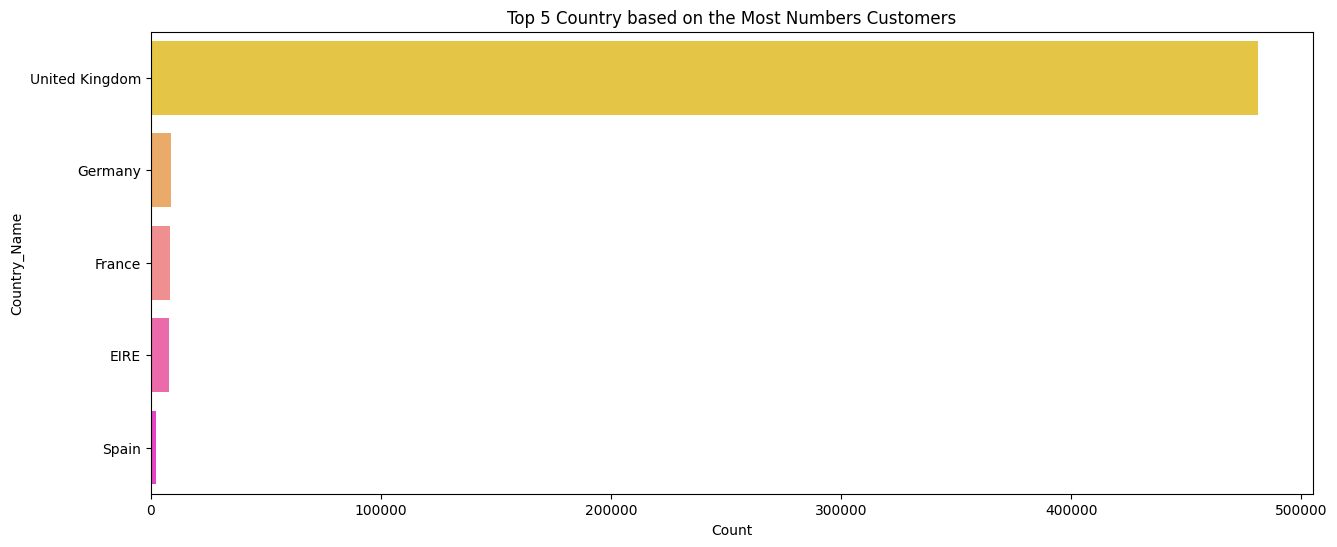

In [41]:
#plot top 5 country name
plt.figure(figsize=(15,6))
plt.title('Top 5 Country based on the Most Numbers Customers')
sns.barplot(x='Count',y='Country_Name',data=country_df[:5], palette='spring_r');

*From this graph we can see that most of the customers are from United Kingdom that make sense aas company is from UK bases after that we have Germany ,France ,EIRE and Spain*

##### 1. Why did you pick the specific chart?

##### 2. What is/are the insight(s) found from the chart?

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

#### Chart - 4

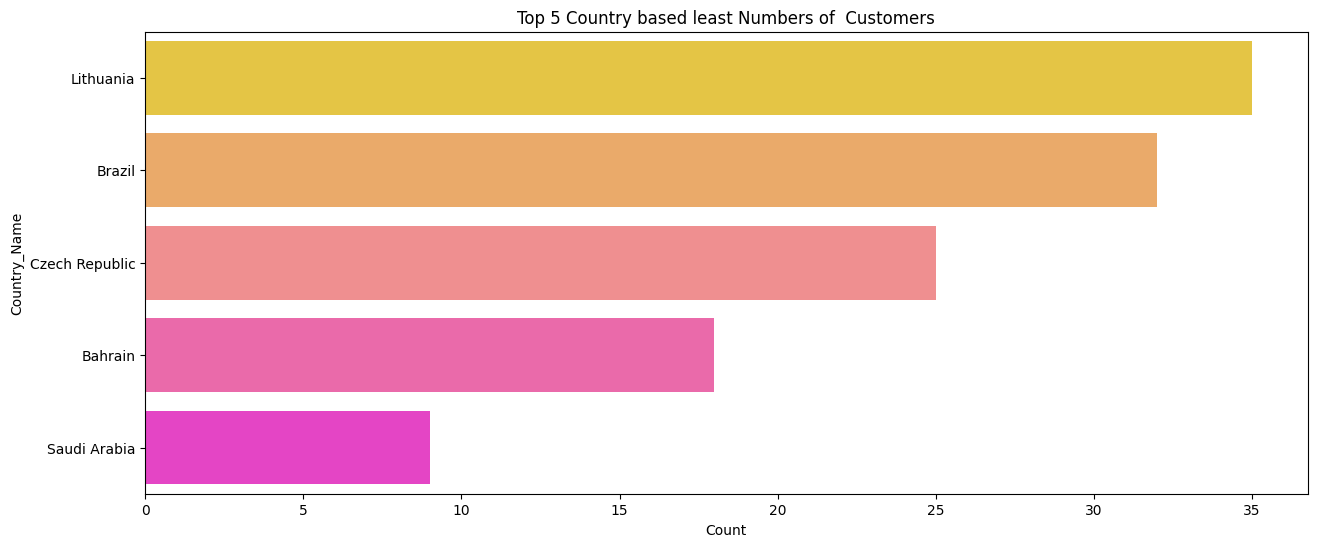

In [42]:
#plot bottom 5 country name
plt.figure(figsize=(15,6))
plt.title('Top 5 Country based least Numbers of  Customers')
sns.barplot(x='Count',y='Country_Name',data=country_df[-5:], palette='spring_r');

##### 1. Why did you pick the specific chart?

##### 2. What is/are the insight(s) found from the chart?

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

#### Chart - 5

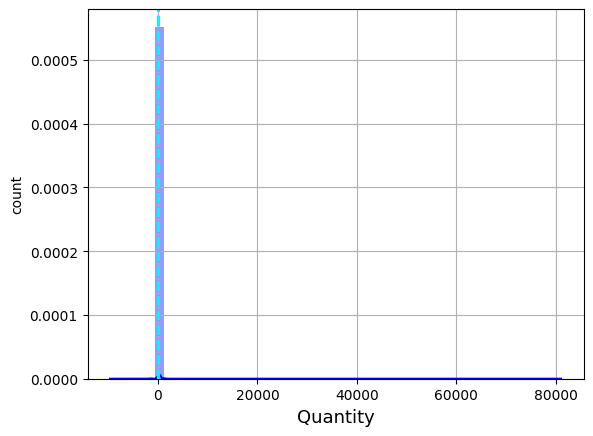

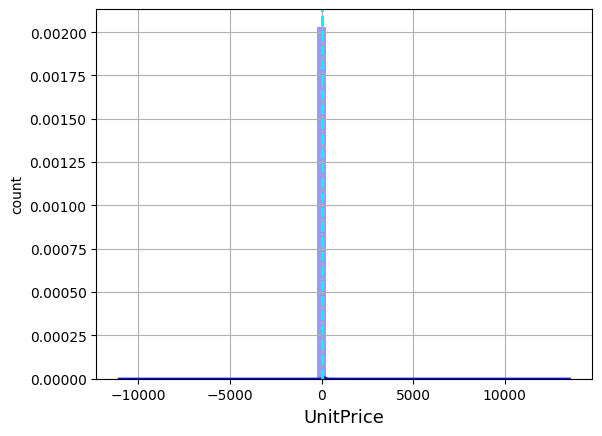

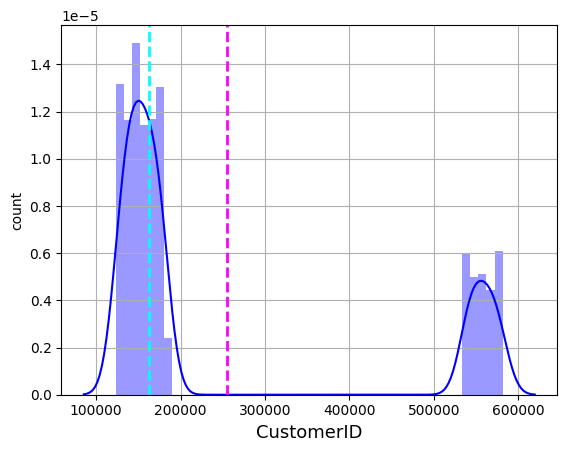

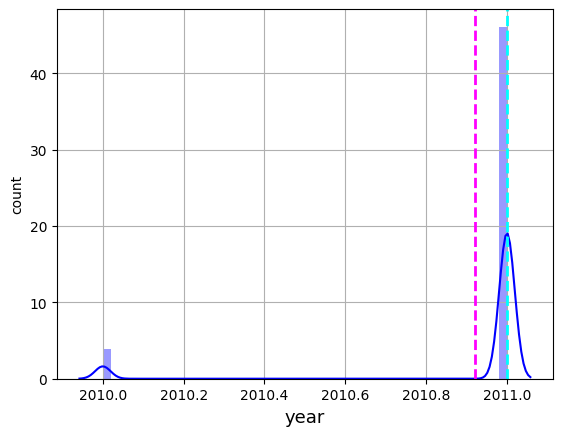

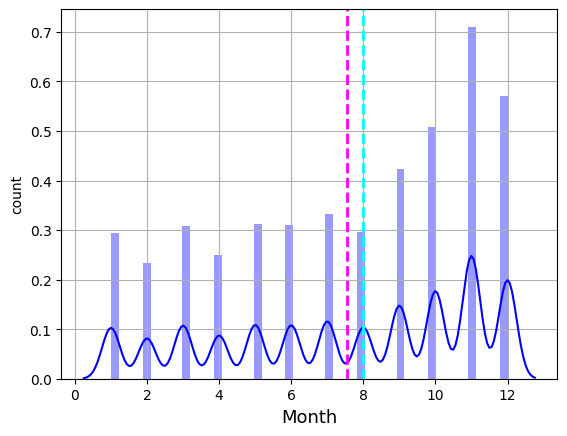

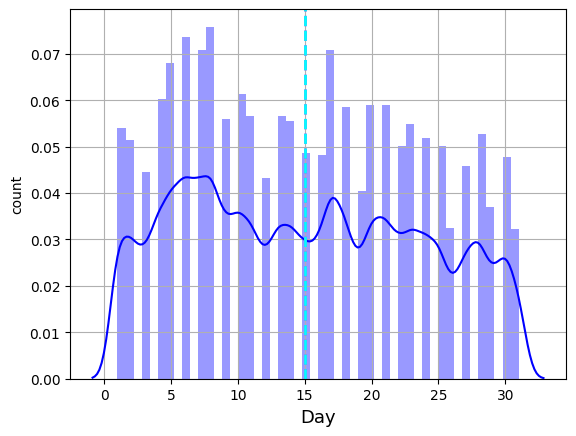

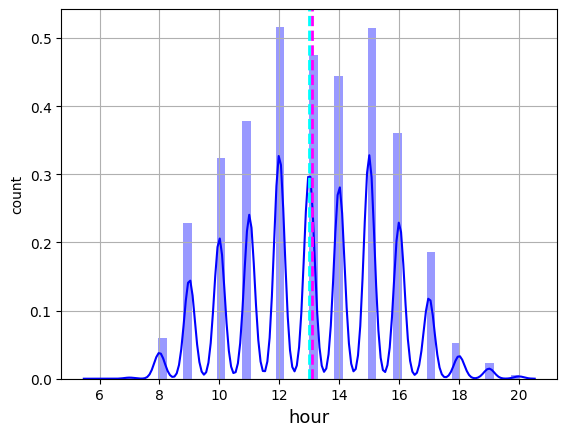

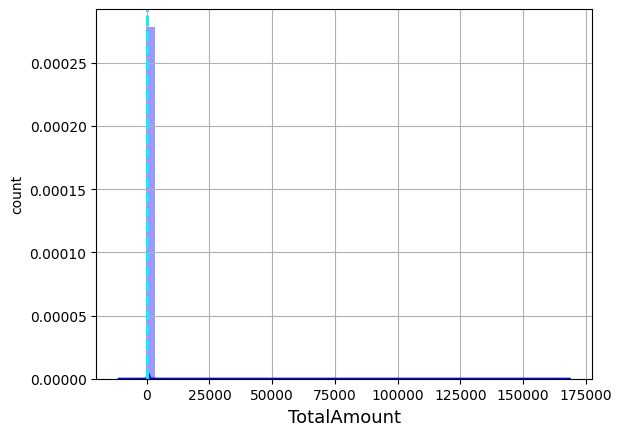

In [43]:
# checking distribution for numerical features
for col in df.select_dtypes([int,float]).columns:

    sns.distplot(df[col], color='blue')

   #PLotting the mean and median
    plt.axvline(df[col].mean(), color='magenta', linestyle='dashed', linewidth=2)
    plt.axvline(df[col].median(), color='cyan', linestyle='dashed', linewidth=2)
    plt.xlabel(col, fontsize=13)
    plt.ylabel('count')
    plt.grid()
    plt.show()

##### 1. Why did you pick the specific chart?

##### 2. What is/are the insight(s) found from the chart?

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

#### Chart - 6

<Axes: >

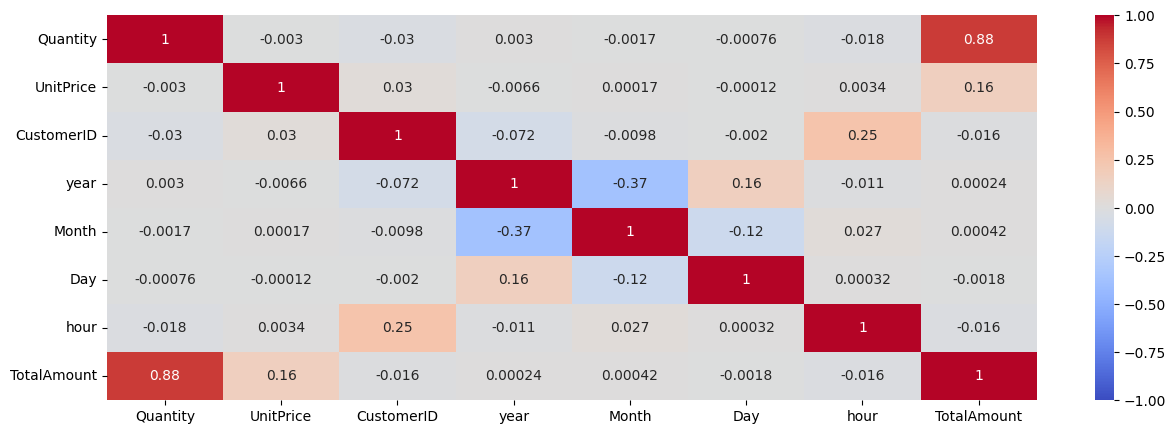

In [44]:
# Cecking correlation
plt.figure(figsize=(15,5))
sns.heatmap(df.corr(),annot=True,cmap='coolwarm',vmin=-1,vmax=1)

##### 1. Why did you pick the specific chart?

##### 2. What is/are the insight(s) found from the chart?

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

#### Chart - 7

In [45]:
numeric_features = []
categorical_features = []

# splitting features into numeric and categoric.
'''
If feature has more than 10 categories we will consider it
as numerical_features, remaining features will be added to categorical_features.
'''
for col in df.columns:
  if df[col].nunique() > 10:
    numeric_features.append(col)
  else:
    categorical_features.append(col)

print(f'numeric feature : {numeric_features}')
print(f'category feature : {categorical_features}')

numeric feature : ['InvoiceNo', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'Country', 'CustomerID', 'Month', 'Day', 'hour', 'TotalAmount']
category feature : ['year', 'TimeType']


In [46]:
df.head()

,InvoiceNo,Description,Quantity,InvoiceDate,UnitPrice,Country,CustomerID,year,Month,Day,hour,TotalAmount,TimeType
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,178500,2010,12,1,8,15.30,Morning
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,178500,2010,12,1,8,22.00,Morning
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom,178500,2010,12,1,8,20.34,Morning


In [47]:
numerical_columns = df[['InvoiceNo', 'Description', 'Quantity', 'UnitPrice', 'Country', 'CustomerID', 'Month', 'Day', 'hour', 'TotalAmount']]
numerical_columns

,InvoiceNo,Description,Quantity,UnitPrice,Country,CustomerID,Month,Day,hour,TotalAmount
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom,178500,12,1,8,15.30
1,536365,WHITE METAL LANTERN,6,3.39,United Kingdom,178500,12,1,8,20.34
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2.75,United Kingdom,178500,12,1,8,22.00
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,United Kingdom,178500,12,1,8,20.34
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,United Kingdom,178500,12,1,8,20.34
...,...,...,...,...,...,...,...,...,...,...
541904,581587,PACK OF 20 SPACEBOY NAPKINS,12,0.85,France,126800,12,9,12,10.20
541905,581587,CHILDREN'S APRON DOLLY GIRL,6,2.10,France,126800,12,9,12,12.60
541906,581587,CHILDRENS CUTLERY DOLLY GIRL,4,4.15,France,126800,12,9,12,16.60
541907,581587,CHILDRENS CUTLERY CIRCUS PARADE,4,4.15,France,126800,12,9,12,16.60


##### 1. Why did you pick the specific chart?

##### 2. What is/are the insight(s) found from the chart?

##### 3. Will the gained insights help creating a positive business impact?
Are there any insights that lead to negative growth? Justify with specific reason.

## ***5. Hypothesis Testing***

### Based on your chart experiments, define three hypothetical statements from the dataset. In the next three questions, perform hypothesis testing to obtain final conclusion about the statements through your code and statistical testing

--> Let's define three hypothetical statements and then perform hypothesis testing for each one using the dataset. For the sake of this example, let's assume a significance level (alpha) of 0.05 for all tests.



*   Statement 1: To determine if there is a significant difference in the average "TotalAmount" of sales during the morning compared to the afternoon.

*   Statement 2: Is there a significant difference in the average TotalAmount between customers who experience cancellations and those who do not?
*   Statement 3: Investigating sales disparities across countries using a Two-Sample T-Test to discern differences in product Quantity between the United Kingdom and other nations.

### Hypothetical Statement - 1

#### 1. State Your research hypothesis as a null hypothesis and alternate hypothesis.

Statement 1: To determine if there is a significant difference in the average "TotalAmount" of sales during the morning compared to the afternoon

Null Hypothesis (H0): The average "TotalAmount" for the "TimeType" in the morning is the same as in the afternoon.

Alternative Hypothesis (H1):The average "TotalAmount" for the "TimeType" in the morning is different from that in the afternoon

#### 2. Perform an appropriate statistical test.

In [48]:
from scipy import stats

morning = df[df['TimeType'] == 'Morning']['TotalAmount']
afternoon = df[df['TimeType'] == 'Afternoon']['TotalAmount']

t_stat, p_value = stats.ttest_ind(morning, afternoon)

# Conclusion
if p_value < 0.05:
    result = "Reject the null hypothesis"
else:
    result = "Fail to reject the null hypothesis"

print(f"p-value: {p_value}")
print(f"We {result}.")

p-value: 7.8674250110875725e-31
We Reject the null hypothesis.


***Conclusion*** : There is a significant difference in average TotalAmount between Morning and Afternoon

##### Which statistical test have you done to obtain P-Value?

We performed an Independent Two-Sample T-Test to obtain the P-value.

##### Why did you choose the specific statistical test?

We chose the Independent Two-Sample T-Test because it is appropriate for comparing the means of two independent groups, in this case, "Morning" and "Afternoon." This test helps determine if there is a significant difference in the "TotalAmount" between these two time categories, providing valuable insights into potential variations in sales trends throughout the day.

### Hypothetical Statement - 2

#### 1. State Your research hypothesis as a null hypothesis and alternate hypothesis.

Statement 2:  Is there a significant difference in the average TotalAmount between customers who experience cancellations and those who do not?

Null Hypothesis (H0):  The average "TotalAmount" for customers with "cancellations" is the same as for customers without cancellations.

Alternative Hypothesis (H1):  The average "TotalAmount" for customers with "cancellations" is different from that for customers without cancellations.

#### 2. Perform an appropriate statistical test.

***Conclusion*** : There is no significant difference in average TotalAmount between customers with and without cancellations.

##### Which statistical test have you done to obtain P-Value?

The statistical test performed to obtain the P-Value is the Independent Two-Sample T-Test.

##### Why did you choose the specific statistical test?

We chose the Independent Two-Sample T-Test because it is suitable for comparing the means of two independent groups, in this case, customers with cancellations and customers without cancellations. The test helps determine if there is a significant difference in the "TotalAmount" between these two groups, which is essential for assessing the impact of cancellations on the average purchase amounts.

### Hypothetical Statement - 3

#### 1. State Your research hypothesis as a null hypothesis and alternate hypothesis.

Statement 3:  Investigating sales disparities across countries using a Two-Sample T-Test to discern differences in product Quantity between the United Kingdom and other nations.

Null Hypothesis (H0):  The "Quantity" of products sold in the United Kingdom is the same as the "Quantity" of products sold in other countries.

Alternative Hypothesis (H1):The "Quantity" of products sold in the United Kingdom is different from the "Quantity" of products sold in other countries.  

#### 2. Perform an appropriate statistical test.

In [49]:
uk_sales = df[df['Country'] == 'United Kingdom']['Quantity']
other_country_sales = df[df['Country'] != 'United Kingdom']['Quantity']

t_stat, p_value = stats.ttest_ind(uk_sales, other_country_sales)

# Conclusion
if p_value < 0.05:
    result = "Reject the null hypothesis"
else:
    result = "Fail to reject the null hypothesis"

print(f"p-value: {p_value}")
print(f"We {result}.")

p-value: 7.309725789293177e-46
We Reject the null hypothesis.


***Conclusion*** : There is a significant difference in the Quantity of products sold between the United Kingdom and other countries.

##### Which statistical test have you done to obtain P-Value?

We conducted an Independent Two-Sample T-Test to obtain the P-value.

##### Why did you choose the specific statistical test?

We selected the Independent Two-Sample T-Test because it is suitable for comparing the means of two independent groups (United Kingdom and other countries). This test helps determine if there is a significant difference in the Quantity of products sold between these groups, allowing us to assess cross-country sales variations.






In [50]:
df1 = df.copy() # Creating a copy for the dataset before performing ML

### From the EDA section some assumptions can be made

*   Small to medium quantities of each item are purchased more.
*   Unit price for most products is low.
*   Last quarter of the year has more orders maybe due to the holiday season.
*   As customers buy in large quantites, it is a volume based business.


## 3. **Data Transformation**

### For the purpose of this project - Recency, Frequency and Monetory (RFM) analysis shall be conducted. On the basis of these 3 factors, customers can be classified into different groups. They can be catered by the business depending on the cluster they belong to.

### In this section, an RFM dataframe would be conducted which can be further used in a model for clustering.

### Recency

### Here, the most recent order of customers is identified.

In [51]:
# Most recent date in the dataset
latest_date = max(df['InvoiceDate'])

In [52]:
# Creating a dataframe to find the most recent purchase
recency_df = pd.DataFrame(df.groupby('CustomerID').max()['InvoiceDate'], columns = ['InvoiceDate'])
recency_df.reset_index(inplace = True)

In [53]:
# Calculating days from most recent purchase
recency_df['Recency'] = recency_df['InvoiceDate'].apply(lambda x: (latest_date - x).days)
recency_df = recency_df.loc[: , ['CustomerID', 'Recency']]

### Frequency

### Frequency of purchases by the customers will be calculated.

###Frequency would be calculated with the number of unique invoice numbers, which means the number of different times the customer has been billed for the items bought. This would explain the frequency of sales to the customer.

In [54]:
# Creating a frequency dataframe
freq_df = pd.DataFrame(data = df.groupby('CustomerID').nunique()['InvoiceNo'])
freq_df.reset_index(inplace = True)
freq_df.columns = ['CustomerID', 'Frequency']

### Monetary

### Here, the sum of billed value for each customer will be calculated.

In [55]:
# Creating a dataframe with total billed amount
monetary_df = df.loc[:,['CustomerID', 'Quantity', 'UnitPrice']]
monetary_df['TotalAmount'] = monetary_df.loc[:,'Quantity'] * monetary_df.loc[:,'UnitPrice']

In [56]:
# Grouping by customer ID to find total billed amount per customer
monetary_df = pd.DataFrame(monetary_df.groupby('CustomerID').sum()['TotalAmount'])
monetary_df.reset_index(inplace = True)
monetary_df.columns = ['CustomerID', 'Monetary']

### After creating 3 dataframes for recency, frequency and monetary, each grouped on the basis of customer ID, these can be now merged into one dataframe.

In [57]:
# Merging 3 dataframes to form an RFM dataframe
rec_fre = recency_df.merge(freq_df, on = 'CustomerID' )
rfm_df = rec_fre.merge(monetary_df, on = 'CustomerID')

In [58]:
# First 5 rows of the RFM dataframe
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary
0,123460,325,1,77183.60
1,123470,1,7,4310.00
2,123480,74,4,1797.24
3,123490,18,1,1757.55
4,123500,309,1,334.40


In [59]:
# Information of the RFM dataframe
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6413 entries, 0 to 6412
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  6413 non-null   int64  
 1   Recency     6413 non-null   int64  
 2   Frequency   6413 non-null   int64  
 3   Monetary    6413 non-null   float64
dtypes: float64(1), int64(3)
memory usage: 250.5 KB


In [60]:
# Number of unique customer ID in the original dataframe
df['CustomerID'].nunique()

6413

### As seen the number of unique customer IDs in the original datframe match the RFM dataframe. Hence, we have accounted for all the customers.

In [61]:
# Making the customer ID the index of the dataframe
rfm_df.set_index('CustomerID', inplace= True)

In [62]:
# Statistical Description of the RFM dataset
rfm_df.describe()

,Recency,Frequency,Monetary
count,6413.000000,6413.000000,6413.000000
mean,115.787463,3.213785,1656.009151
std,110.319016,6.520158,7529.386505
min,0.000000,1.000000,-11062.060000
25%,23.000000,1.000000,147.120000
50%,70.000000,1.000000,519.610000
75%,197.000000,3.000000,1476.280000
max,373.000000,210.000000,280206.020000


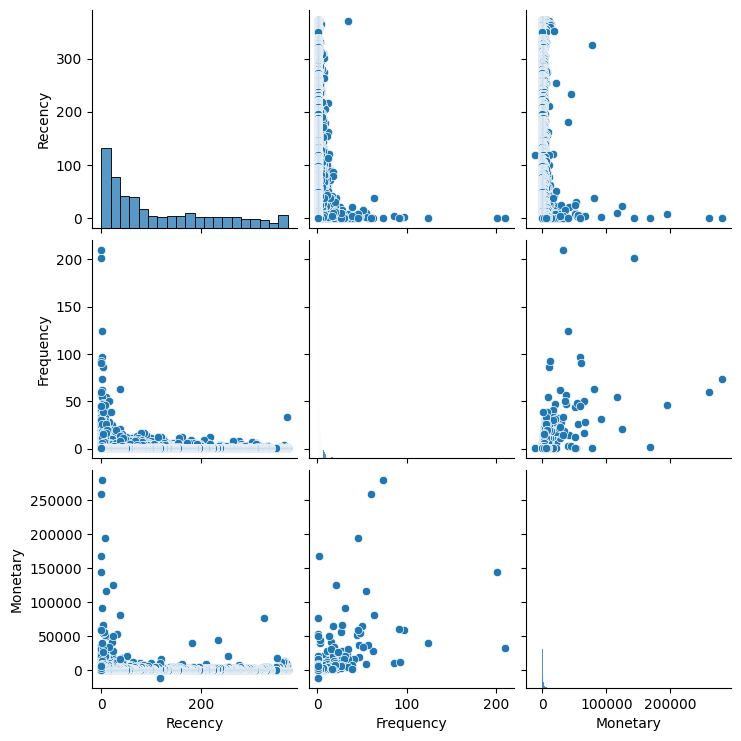

In [63]:
# Graphical representation of the relation between recency, frequency and monetary
sns.pairplot(rfm_df)

### The above pairplot explains the relation between recency, frequency and monetory variables. Each data point represents a customer. It can be seen that :-

*   There are many recent purchaces with higher monetary value than older purchases.
*   Frequency of orders have been higher recently.
*   Frequency and monetary variables have slight linear trend.

### There are some customers who are potential outliers, but these cannot be removed because, for example there is a customer how very recently has had a very high billing value. He could be vital to the business. There is also another customer who has frequently billed a high value. Hence, if these are removed, business could miss classifying their main customers, who could potentially be of high value in the future also.

### The values in the columns have different ranges which can impact analysis, hence, we will scale all the values to one common range

In [64]:
# Importing the scaler
from sklearn.preprocessing import StandardScaler, Normalizer

In [65]:
# Creating a copy of the rfm dataframe
rfm_df_copy = rfm_df.copy()

In [67]:
scaler = StandardScaler()
normal = Normalizer()
scaled_data = scaler.fit_transform(rfm_df_copy)
scaled_data = normal.fit_transform(scaled_data)
rfm_scaled = pd.DataFrame(scaled_data, columns = ['Recency','Frequency','Monetary'])
rfm_scaled.set_index(rfm_df_copy.index, inplace=True)

In [68]:
# First 5 rows of the scaled data
rfm_scaled.head()

,Recency,Frequency,Monetary
CustomerID,,,
123460,0.185663,-0.033240,0.982051
123470,-0.837349,0.467315,0.283663
123480,-0.951824,0.303001,0.047134
123490,-0.933743,-0.357661,0.014206
123500,0.977005,-0.189404,-0.097916


## 4. **Clustering**

In [69]:
# Importing libraries necessary for clustering
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score

In [70]:
# Creating an instance of the model
kmeans = KMeans()

### KMeans requires the number of clusters to be specified during the model building process. To know the right number of clusters, methods such as elbow method and silhouette analysis can be used. These methods will help in selection of the optimum number of clusters.

### Elbow Method

In [71]:
# Using the elbow method to find out optimum number of clusters, with different metrics
def elbow_method(X):
  ''' Displays elbow curves with different metrics '''

  metrics = ['distortion', 'calinski_harabasz', 'silhouette']

  for m in metrics:
    visualizer = KElbowVisualizer(kmeans, k = (2,10), metric = m)
    visualizer.fit(X)
    visualizer.poof()

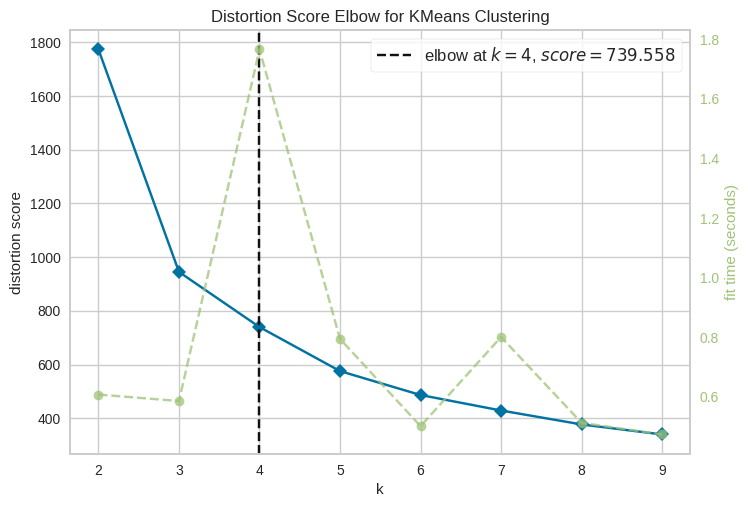

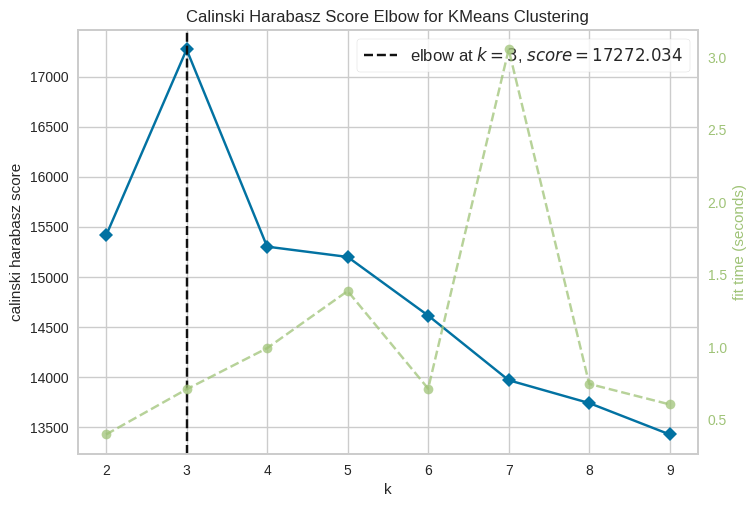

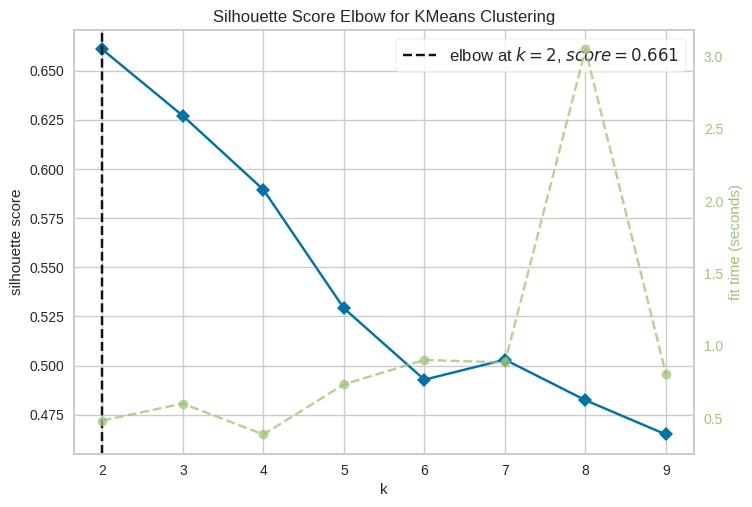

In [72]:
# Using the elbow method function to understand optimum number of clusters
elbow_method(rfm_scaled)

### Silhouette Analysis

In [74]:
# Creating a function to calculate silhouette scores
def sil_score(input, k):
  ''' Returns a dataframe with sillhouette scores of different clusters in the data '''

  sil_df = pd.DataFrame(columns = ['Clusters', 'Silhouette Score'])

  for i in range(2,k+1):
    kmeans = KMeans(n_clusters = i)
    labels = kmeans.fit_predict(input)
    score = silhouette_score(input, labels)
    sil_df = sil_df.append({'Clusters' : i,
                            'Silhouette Score' : score}, ignore_index = True)

  return sil_df

In [75]:
# Using the function to display silhoutte scores at different number of clusters
sil_score(rfm_scaled,10)

,Clusters,Silhouette Score
0,2.0,0.660706
1,3.0,0.626876
2,4.0,0.589455
3,5.0,0.529150
4,6.0,0.492836
5,7.0,0.504509
6,8.0,0.482419
7,9.0,0.465212
8,10.0,0.465783


In [76]:
# Creating a function for silhouette plot visualization
def sil_visual(input, k):
  ''' Visualize the silhouette plot with different clusters'''

  for i in range(2,k+1):
    kmeans = KMeans(n_clusters = i)
    visualizer = SilhouetteVisualizer(kmeans)
    visualizer.fit(input)
    visualizer.poof()

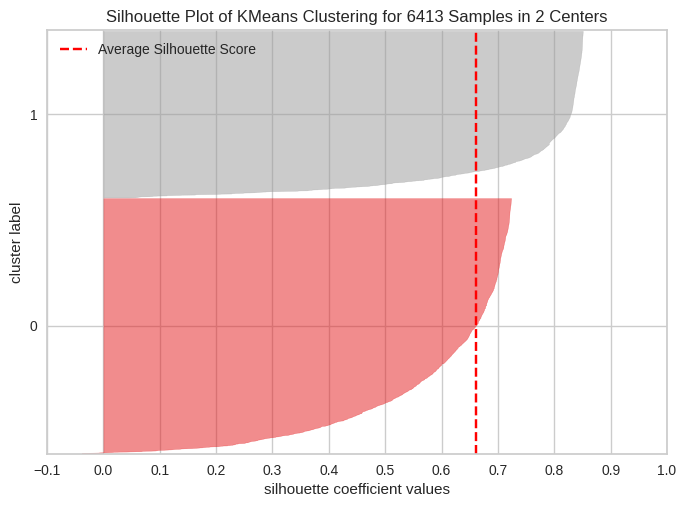

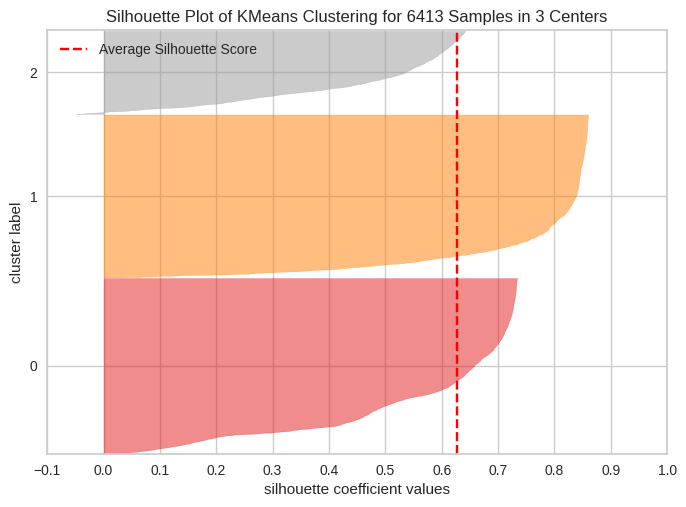

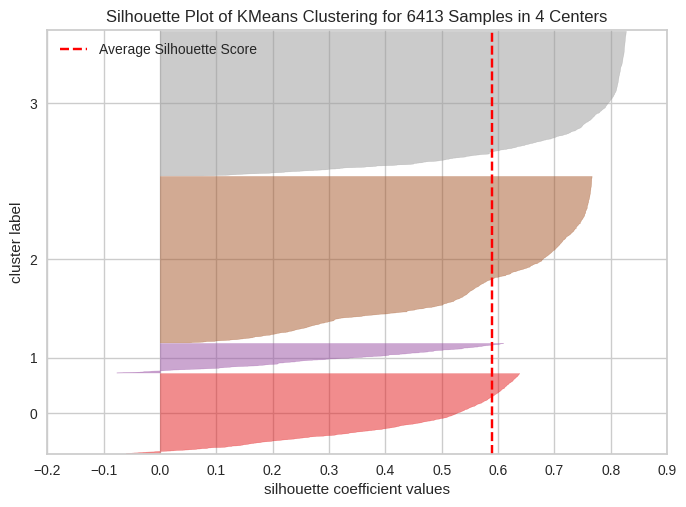

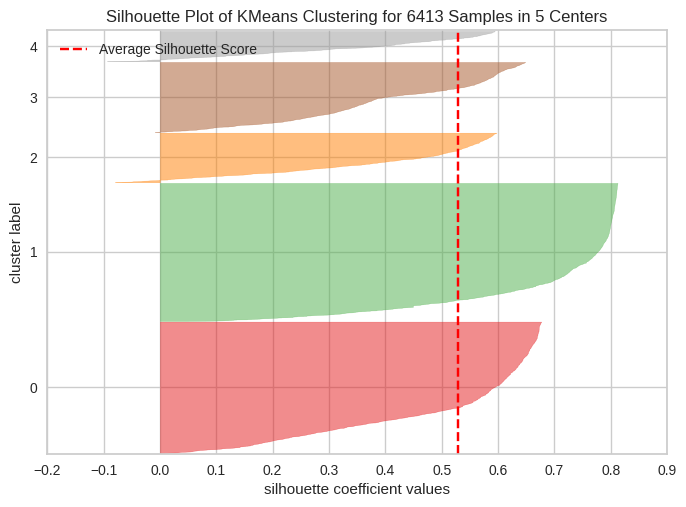

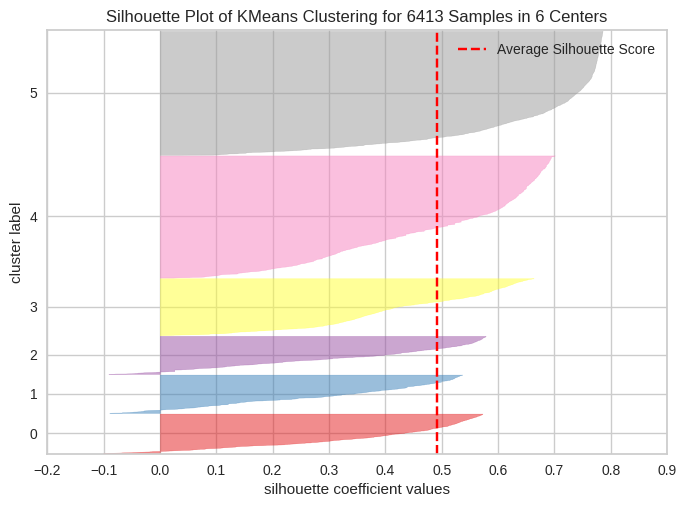

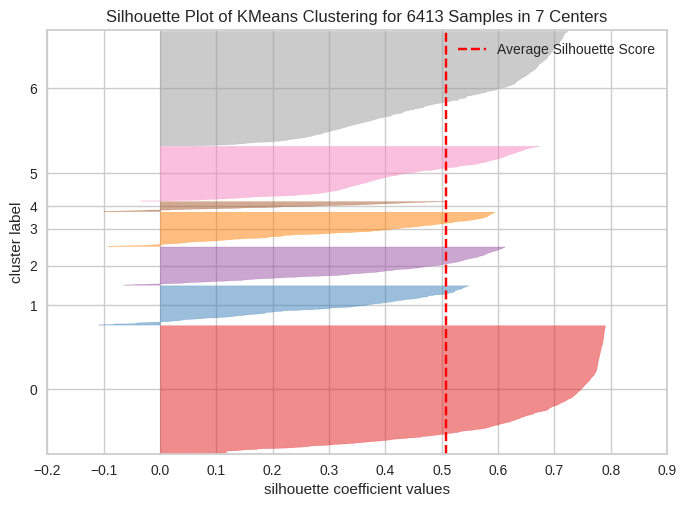

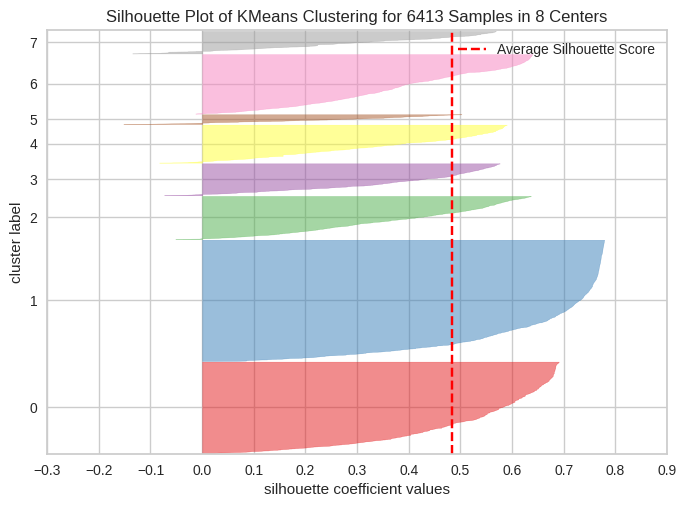

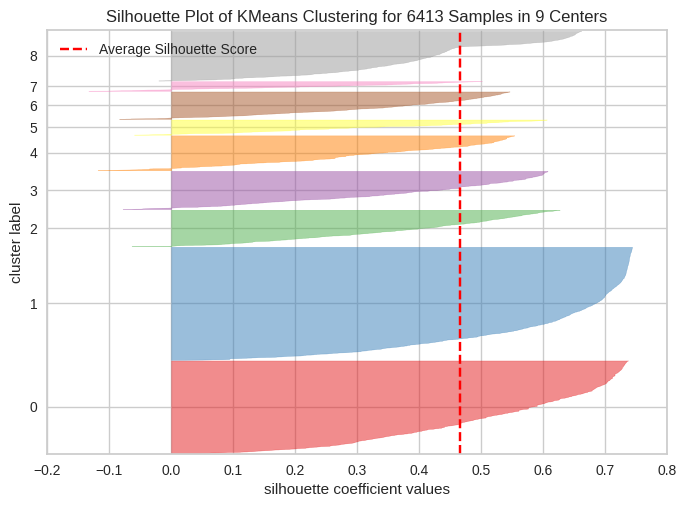

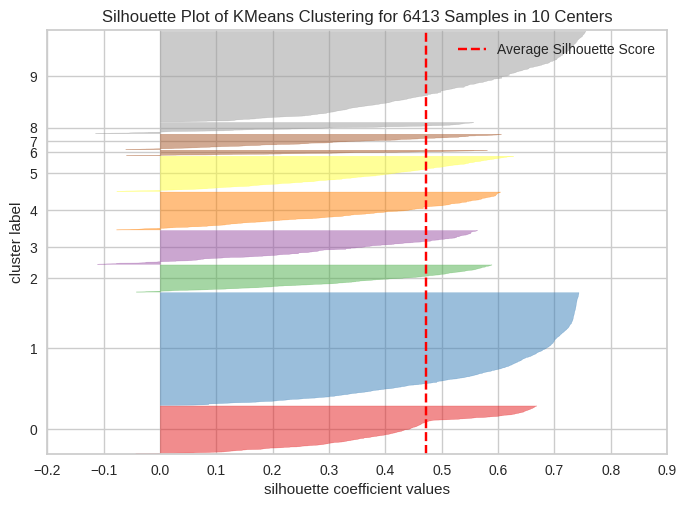

In [77]:
# Applying the silhouette visualization function for different clusters.
sil_visual(rfm_scaled, 10)

### From the elbow method and silhouette analysis, it is clearly understood that, 3 clusters is performing the best. Hence, 3 clusters will be selected to build the KMeans model and classify the customers.

### Building the KMeans Model

In [78]:
# KMeans with 3 clusters
kmeans = KMeans(n_clusters = 3, random_state=10)

In [79]:
# Fitting the model to the data
kmeans.fit(rfm_scaled)

KMeans(n_clusters=3, random_state=10)

### Now predictions of the clusters can be made, these predictions can be represented as a column in the RFM dataframe, which can help in profiling the clusters

In [80]:
# Creating cluster labels for the data and appending it to the RFM dataframe
labels = kmeans.predict(rfm_scaled)
rfm_df_copy['Cluster'] = labels

In [81]:
# First 5 rows of the RFM dataframe after adding the cluster column
rfm_df_copy.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
123460,325,1,77183.60,2
123470,1,7,4310.00,2
123480,74,4,1797.24,2
123490,18,1,1757.55,0
123500,309,1,334.40,1


## 5. **Cluster Profiling**

In [82]:
# Grouping by clusters to understand the profiles
rfm_df_copy.groupby('Cluster').mean()

,Recency,Frequency,Monetary
Cluster,,,
0,43.039700,1.726966,698.906657
1,238.089005,1.293194,643.938659
2,28.931746,10.149206,5678.576365


In [83]:
# Number of customers belonging to each cluster
rfm_df_copy['Cluster'].value_counts()

0    2670
1    2483
2    1260
Name: Cluster, dtype: int64

### By grouping RFM dataframe on the basis of clusters, and using mean to summarize the variables we understand that :-

### 1. Cluster 0 comprises of customers who are very recent, frequent and also contribute largely to the sales.
### 2. Cluster 1 comprises of customers who are moderately recent, frequent and contribute an average amount to sales
### 3. Cluster 2 comprises of customers who made purchaces a long time ago and purchase infrequently and contribute the least towards the sales of the company.

### We can name these clusters as follows :-

### Cluster 0 can be named high value and loyal customers.
### Cluster 1 can be named average value and ordinary customers.
### Cluster 2 can be named low value and casual customers.


<Axes: xlabel='Recency', ylabel='Frequency'>

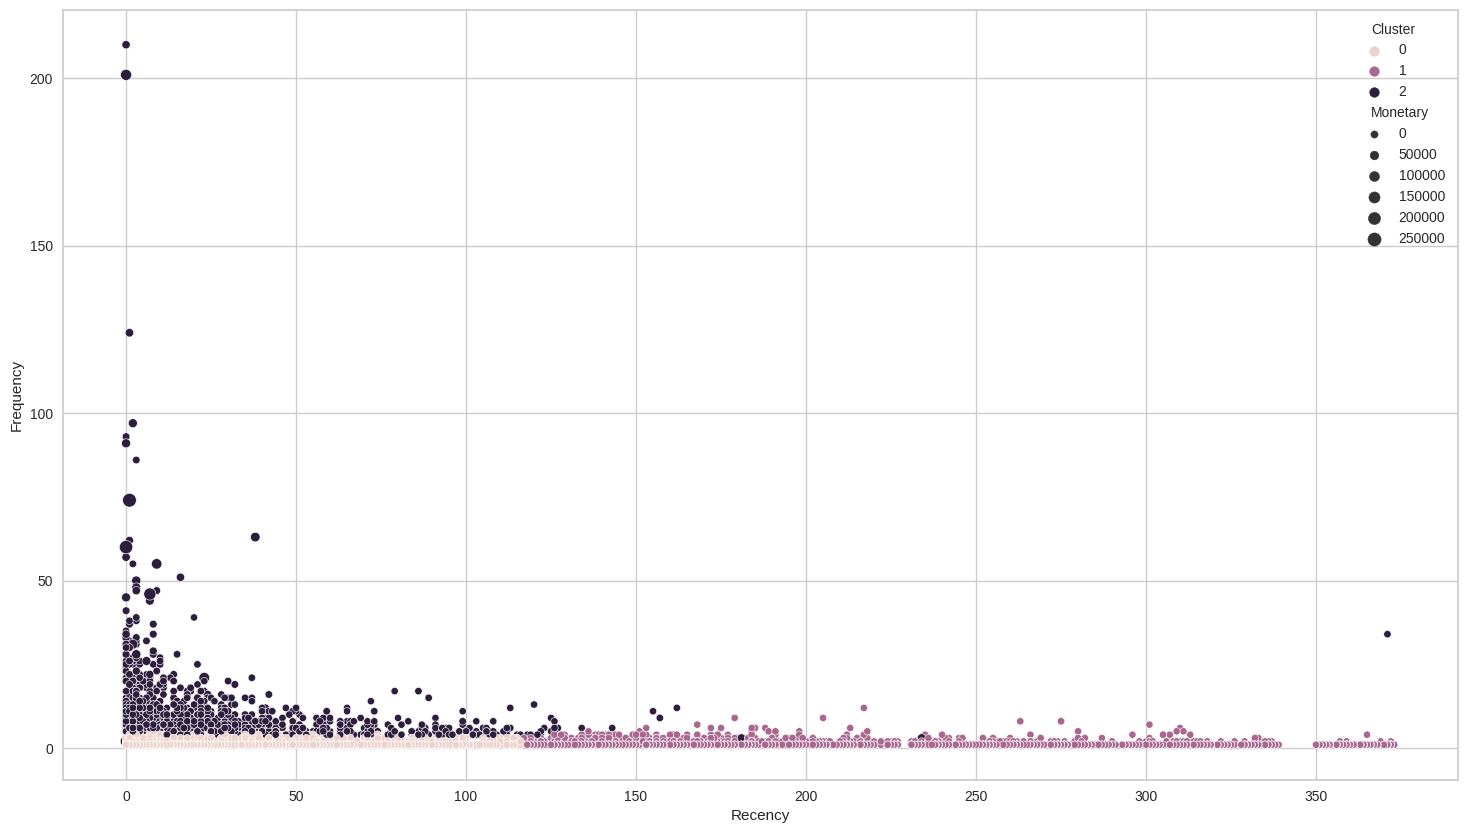

In [84]:
# Creating a scatter plot to understand the clusters visually
plt.figure(figsize = (18,10))
sns.scatterplot(x = rfm_df_copy['Recency'], y = rfm_df_copy['Frequency'], size= rfm_df_copy['Monetary'], hue = rfm_df_copy['Cluster'])

In [85]:
# Library import for dendrogram
import scipy.cluster.hierarchy as shc

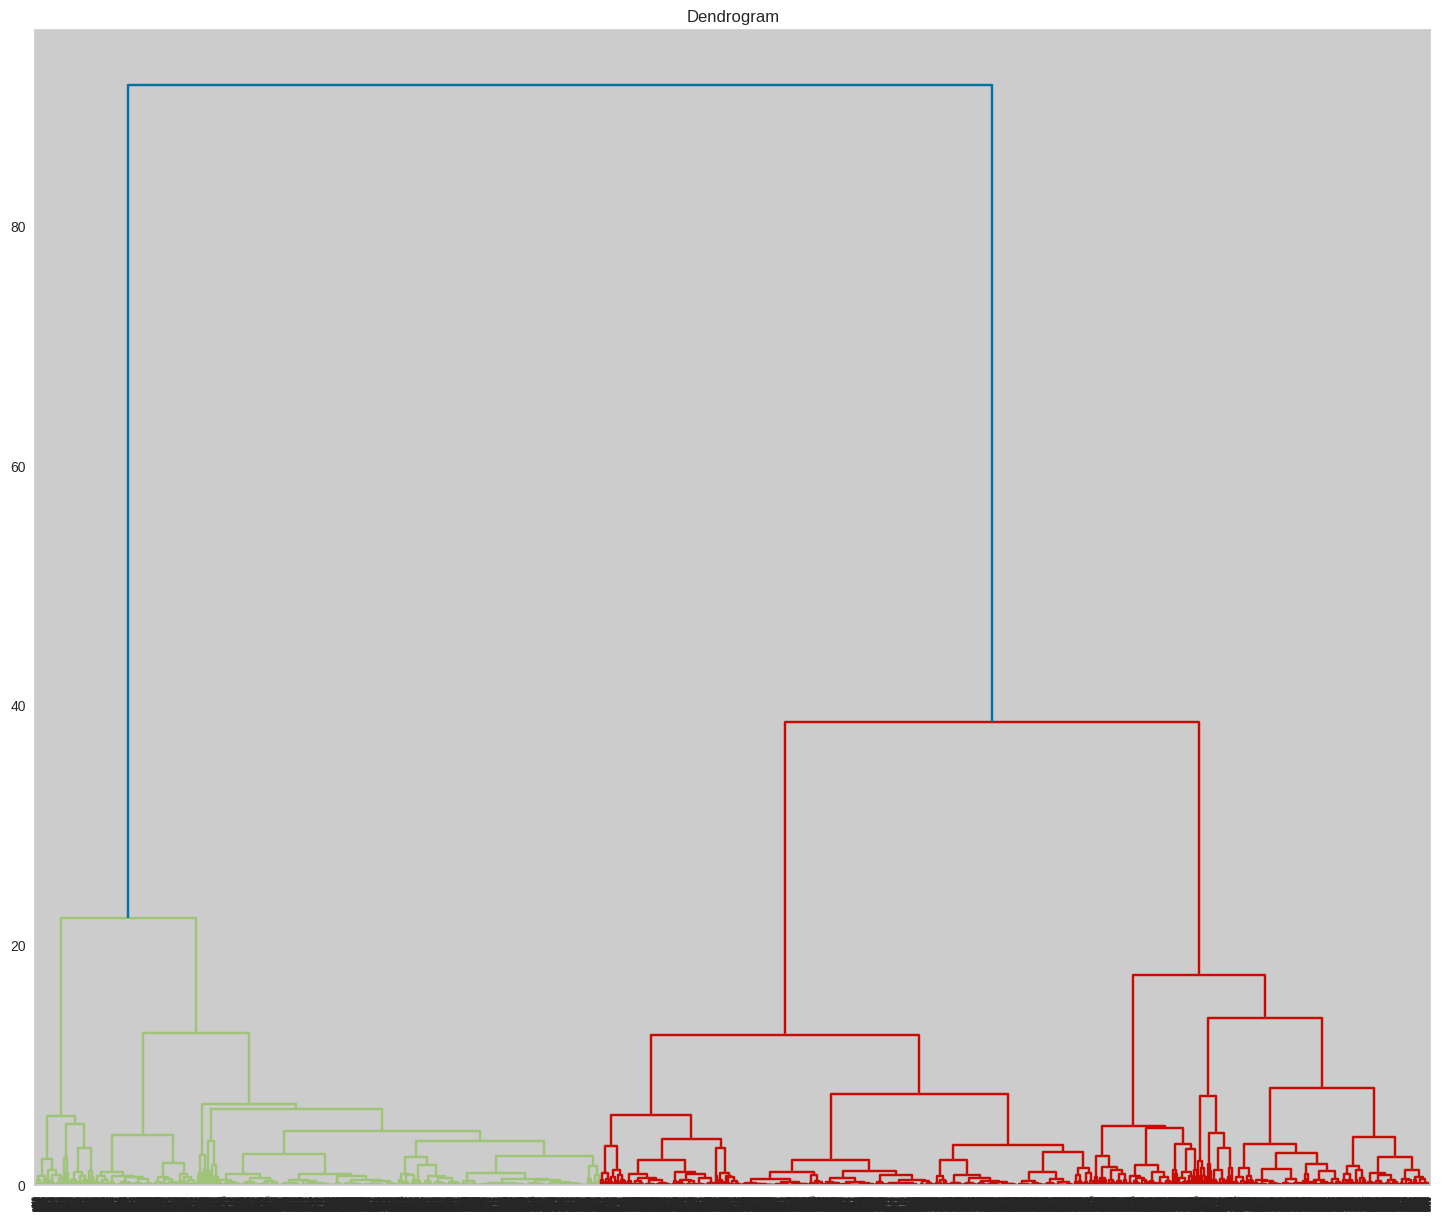

In [86]:
# Creating a dendrogram to visualize the clusters
plt.figure(figsize = (18,15))
plt.title('Dendrogram')
dend = shc.dendrogram(shc.linkage(scaled_data, method='ward'))

### From the above dendrogram, it is clearly seen that 3 clusters are the optimum choice even through an hierarchical method.

## **Conclusion**

### In this project, a translational dataset from a UK based online store was used. The data set contained various columns such as item name, quantity, unit price, country from which the order was made, etc. It contains data for almost a period of one year. The main aim of the project was to classify the customers into different segments. These segments will have a defining character of their own. This will help the business cater better to their customers which inturn could increase the profits.

### The project has been done in 5 parts mainly :-

 1. Data Cleaning - In this section the null values, cancelled orders and outliers were removed.

 2. Exploratory Data Analysis (EDA) - In this section, univariate and bivariate analysis was conducted to gain deeper understanding of the data. Some insights were found, such as - the last quarter has greater orders of different items, UK has the highest number of orders, the business sell medium to low quantities of single items and the unit price is also lower. 'Pack of 72 retrospot cake cases' were most sold in terms of quantity.

 3. Data Transformation - In this section, a Recency, Frequency and Monetary analysis was developed for each customer ID. These 3 variables can help segment customers strategically.

 4. Clustering - In this section, the optimum number of clusters were chosen via elbow method and silhouette analysis. It was found that 3 clusters would be the most optimum. A KMeans model with 3 clusters was developed. Each customer ID was clustered into one of the 3 clusters.

 5. Cluster Profiling - In this section, the average of recency, frequency and monetary values for each customer segment was identified. On the basis of this, the 3 clusters were named - high value and loyal customers, average value and ordinary customers, low value and casual customers.

### On the basis of this analysis, the business can offer attractive deals to its average and low value customers and they can also treat their high value customers with special business offers such as loyalty points.